In [2]:
import os
import math
import sys
sys.path.append('..')

import random
import torch
import pandas as pd
import torch.nn as nn

from rocket_rag.transform import smoothing
from rocket_rag.rocket import RocketConv, ChannelMix, PPVThresholds, Rocket

In [3]:
RAW_DATA_DIR = '../data/raw/'
INSTANCES_DIR = '../data/instances/'
INFERENCE_DIR = '../data/inference/'
STATES = ['normal', 
          'backlash1', 'backlash2',
          'lackLubrication1', 'lackLubrication2',
          'spalling1', 'spalling2', 'spalling3', 'spalling4',
          'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']
SMOOTHING_PE_WINDOW_SIZE = 20
SMOOTHING_CUR_WINDOW_SIZE1 = 5
SMOOTHING_CUR_WINDOW_SIZE2 = 10
SMOOTHING_CUR_WINDOW_SIZE3 = 15

all_instances = {str(load) + '_' + str(state): os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES for load in LOADS}
normal_20kg = all_instances['20kg_normal']
rand_filename = os.path.join(INSTANCES_DIR, '20kg', 'normal', random.choice(normal_20kg))

current = smoothing(ts_df=pd.read_csv(rand_filename), field='current')
position_error = smoothing(ts_df=pd.read_csv(rand_filename), field='position_error')

In [25]:
input_tensor = torch.stack((torch.tensor(current), torch.tensor(position_error)))
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor

tensor([[[ 4.1650e-01,  5.1959e-01,  6.0716e-01,  6.7921e-01,  7.3574e-01,
           7.7675e-01,  8.0223e-01,  8.1220e-01,  7.8462e-01,  7.3169e-01,
           6.8224e-01,  6.3332e-01,  6.0341e-01,  5.8432e-01,  5.8182e-01,
           5.7233e-01,  5.8316e-01,  5.8411e-01,  5.9395e-01,  6.0774e-01,
           6.1541e-01,  6.2331e-01,  6.3347e-01,  6.5628e-01,  6.7194e-01,
           6.7914e-01,  6.9692e-01,  7.1386e-01,  7.3155e-01,  7.3499e-01,
           7.6454e-01,  7.7365e-01,  7.9978e-01,  8.0688e-01,  8.1483e-01,
           8.1427e-01,  8.2127e-01,  8.1752e-01,  8.0928e-01,  7.9311e-01,
           7.8033e-01,  7.6026e-01,  7.4163e-01,  7.3495e-01,  7.4010e-01,
           7.3702e-01,  7.4110e-01,  7.4101e-01,  7.4696e-01,  7.5239e-01,
           7.6086e-01,  7.6598e-01,  7.6865e-01,  7.7724e-01,  7.8619e-01,
           7.9110e-01,  7.9340e-01,  7.8837e-01,  7.7656e-01,  7.7221e-01,
           7.6413e-01,  7.6241e-01,  7.6092e-01,  7.5861e-01,  7.5666e-01,
           7.5517e-01,  7

In [26]:
def deduce_dilation_values(
        max_kernel_span: int,
        kernel_length: int,
        max_dilations: int,
    ) -> None:
        """Create dilation values following the scheme in the original paper.

        Dilation values are chosen according to the number of observations
        with the formula in the paper.
        """
        max_exponent = math.log((max_kernel_span - 1) / (kernel_length - 1), 2)
        integers = (
            (2 ** torch.linspace(0, max_exponent, max_dilations)).to(dtype=int).tolist()
        )
        return list(set(integers))

In [27]:
dilations = deduce_dilation_values(max_kernel_span=input_tensor.shape[-1], kernel_length=9, max_dilations=32)
dilations

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 22, 25, 28, 31, 35, 40]

In [28]:
rocket_conv = RocketConv(in_channels=2, dilation=dilations[1])

In [29]:
conv = rocket_conv(input_tensor.float())

In [30]:
conv

tensor([[[[-3.3463, -3.5194, -4.0285,  ...,  2.8676,  3.9219,  3.9150],
          [-3.3463, -3.5194, -2.7790,  ...,  2.9169,  3.9825,  3.9869]],

         [[-2.0968, -1.9607, -2.2070,  ...,  2.9888,  4.0657,  4.0814],
          [-1.5248, -1.4818, -1.8213,  ...,  3.0833,  0.9114,  0.8770]],

         [[-1.1390, -1.1892, -1.6218,  ..., -0.1211,  0.9114,  0.8770],
          [-0.9396, -1.0829, -1.6746,  ..., -0.1211,  0.9114,  0.8770]],

         ...,

         [[11.6839, 13.1794, 13.2138,  ..., -0.3854, -0.8324, -0.9931],
          [13.6871, 14.5702, 13.7185,  ..., -0.3854, -0.8324, -0.9931]],

         [[15.6317, 17.1932, 17.0546,  ..., -1.0906, -0.5275, -0.3064],
          [16.1363, 17.0194, 16.4416,  ..., -1.0906, -0.5275, -0.3064]],

         [[18.1394, 18.4103, 16.9462,  ..., -1.0906, -0.5275, -0.3064],
          [21.3672, 21.0257, 18.9493,  ..., -0.4039, -0.5275, -0.3064]]]])

In [31]:
channel_mix = ChannelMix(in_channels=rocket_conv.in_channels, in_kernels=rocket_conv.num_kernels)

In [32]:
chan_mix = channel_mix(conv)

In [33]:
chan_mix

tensor([[[[-3.3463, -3.5194, -4.0285,  ...,  2.8676,  3.9219,  3.9150],
          [-3.3463, -3.5194, -2.7790,  ...,  2.9169,  3.9825,  3.9869]],

         [[-2.0968, -1.9607, -2.2070,  ...,  2.9888,  4.0657,  4.0814],
          [-1.5248, -1.4818, -1.8213,  ...,  3.0833,  0.9114,  0.8770]],

         [[-1.1390, -1.1892, -1.6218,  ..., -0.1211,  0.9114,  0.8770],
          [-0.9396, -1.0829, -1.6746,  ..., -0.1211,  0.9114,  0.8770]],

         ...,

         [[11.6839, 13.1794, 13.2138,  ..., -0.3854, -0.8324, -0.9931],
          [13.6871, 14.5702, 13.7185,  ..., -0.3854, -0.8324, -0.9931]],

         [[15.6317, 17.1932, 17.0546,  ..., -1.0906, -0.5275, -0.3064],
          [16.1363, 17.0194, 16.4416,  ..., -1.0906, -0.5275, -0.3064]],

         [[18.1394, 18.4103, 16.9462,  ..., -1.0906, -0.5275, -0.3064],
          [21.3672, 21.0257, 18.9493,  ..., -0.4039, -0.5275, -0.3064]]]])

In [34]:
ppv_thresholds = PPVThresholds(num_thresholds=1)

In [35]:
ppv_thresholds.fit(chan_mix)

In [36]:
thres = ppv_thresholds(chan_mix)
thres

tensor([[[[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3827]],

         [[0.3827],
          [0.3

In [ ]:
rocket = Rocket(in_channels=input_tensor.shape[1], max_kernel_span=20)

In [ ]:
rocket.fit(input_tensor.float())
emb = rocket(input_tensor.float())

In [ ]:
emb.shape

torch.Size([1, 9744])

In [ ]:
emb

tensor([[0.3827, 0.7623, 0.1481,  ..., 0.3148, 0.6944, 0.0772]])

In [ ]:
current_tensor = torch.tensor(current).unsqueeze(dim=0).unsqueeze(dim=0)
current_tensor.shape

torch.Size([1, 1, 324])

In [ ]:
rocket = Rocket(in_channels=current_tensor.shape[1], max_kernel_span=25)

In [ ]:
rocket.fit(current_tensor.float())

In [ ]:
cur_emb = rocket(current_tensor.float())
cur_emb.shape
cur_emb

tensor([[0.3827, 0.7623, 0.1481,  ..., 0.1327, 0.5154, 0.8951]])

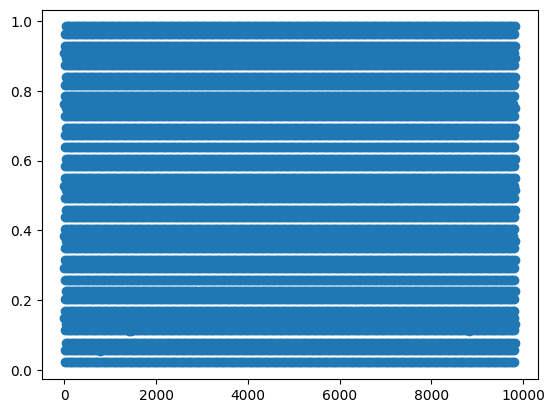

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

cur_emb_features = cur_emb.squeeze().tolist()
plt.scatter(np.arange(len(cur_emb_features)), cur_emb_features)
plt.show()

In [ ]:
from tsai.imports import default_device
from tsai.models import MINIROCKET_Pytorch

In [ ]:
mrf = MINIROCKET_Pytorch.MiniRocketFeatures(c_in=1, seq_len=len(current)).to(default_device())

In [ ]:
mrf.fit(current_tensor.float().to(default_device()))

In [ ]:
f = MINIROCKET_Pytorch.get_minirocket_features(current_tensor.float().to(default_device()), mrf)

In [ ]:
f.squeeze()

array([0.38271606, 0.7623457 , 0.14814815, ..., 1.        , 1.        ,
       0.5       ], dtype=float32)

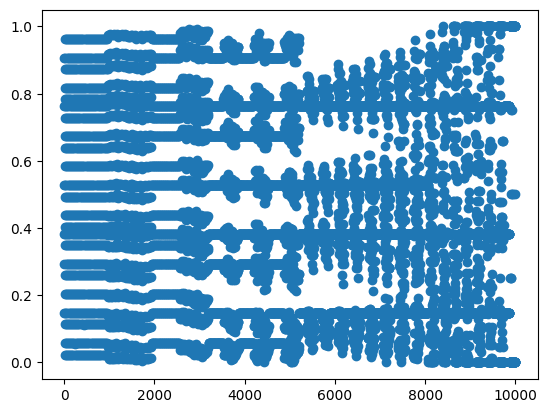

In [ ]:
plt.scatter(np.arange(len(f.squeeze())), f.squeeze())
plt.show()

In [4]:
import numpy as np
from rocket_rag.transform import rocket_transform

In [5]:
cur_array = np.expand_dims(np.array(current, dtype=np.float32), axis=(0, 1))

In [6]:
rocket_transform(cur_array)

array([0.38271606, 0.7623457 , 0.14814815, ..., 1.        , 1.        ,
       0.5       ], dtype=float32)